<a href="https://colab.research.google.com/github/abhilb/Open-eye-closed-eye-classification/blob/main/part2/MRL_Dataset_CNN_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pathlib import Path
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Softmax, InputLayer, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!gdown https://drive.google.com/uc?id=1JkdFa4fj0DMrDHju7QqC4EiUfJD9Cjws

Downloading...
From: https://drive.google.com/uc?id=1JkdFa4fj0DMrDHju7QqC4EiUfJD9Cjws
To: /content/mrl_dataset.npz
696MB [00:14, 48.4MB/s]


In [3]:
dataset_path = Path('mrl_dataset.npz').absolute().resolve()
data = np.load(str(dataset_path))
X = data['data']
y = data['labels']
data.close()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(f"Number of samples in training dataset: {X_train.shape[0]}")
print(f"Number of samples in testing dataset : {X_test.shape[0]}")

Number of samples in training dataset: 56881
Number of samples in testing dataset : 28017


In [5]:
model = Sequential()
model.add(InputLayer(input_shape=(32, 32, 1)))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.5))
model.add(Conv2D(32, 3, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Conv2D(32, 3, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Softmax())

In [6]:
opt = Adam(learning_rate=0.0001)
loss = SparseCategoricalCrossentropy()
metrics = ['accuracy']
callback = EarlyStopping(monitor='loss', patience=3)
model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
dropout_2 (Dropout)          (None, 11, 11, 32)        0

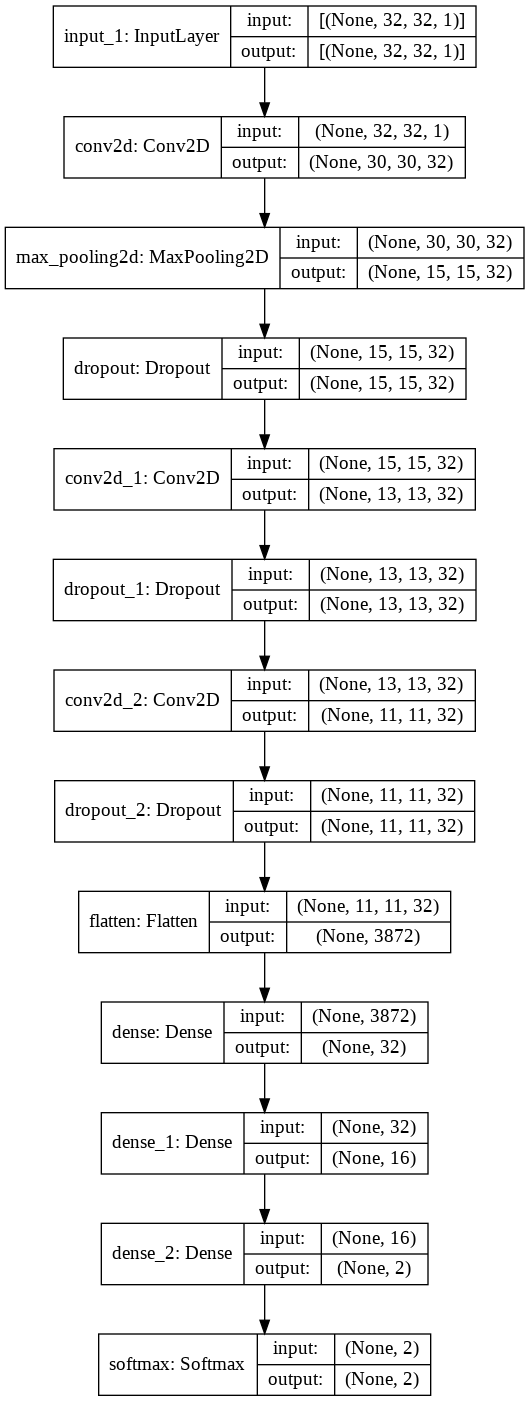

In [8]:
plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [9]:
from tensorflow.keras.utils import Sequence
from typing import Tuple

class DataGenerator(Sequence):
  def __init__(self, batch_size: int,
               dims: Tuple[int, int],
               data, labels):
    self.batch_size = batch_size
    self.dims = dims
    self.data = np.hstack((data, labels))
    self.nb_samples = self.data.shape[0]
    self.indexes = np.arange(self.nb_samples)
    self.on_epoch_end()

  def __len__(self):
    return self.nb_samples // self.batch_size

  def __getitem__(self, index):
    start_idx = index * self.batch_size
    end_idx = (index + 1) * self.batch_size
    data_slice = self.data[start_idx:end_idx, :]
    X = data_slice[:,0:-1].reshape(-1,*self.dims)
    y = data_slice[:,-1]
    return X, y

  def on_epoch_end(self):
    np.random.shuffle(self.data)


In [10]:
train_generator = DataGenerator(64, (32, 32, 1), X_train[:40000,:], y_train[:40000])
valid_generator = DataGenerator(32, (32, 32, 1), X_train[40000:,:], y_train[40000:])

history = model.fit(train_generator, validation_data=valid_generator, epochs=100)

Epoch 1/100
625/625 [==============================] - 35s 7ms/step - loss: 0.4991 - accuracy: 0.7521 - val_loss: 0.3608 - val_accuracy: 0.8727
Epoch 2/100
625/625 [==============================] - 4s 6ms/step - loss: 0.3442 - accuracy: 0.8692 - val_loss: 0.2813 - val_accuracy: 0.8961
Epoch 3/100
625/625 [==============================] - 4s 6ms/step - loss: 0.2817 - accuracy: 0.8915 - val_loss: 0.2344 - val_accuracy: 0.9111
Epoch 4/100
625/625 [==============================] - 4s 6ms/step - loss: 0.2442 - accuracy: 0.9047 - val_loss: 0.2051 - val_accuracy: 0.9243
Epoch 5/100
625/625 [==============================] - 4s 6ms/step - loss: 0.2152 - accuracy: 0.9167 - val_loss: 0.1725 - val_accuracy: 0.9379
Epoch 6/100
625/625 [==============================] - 4s 6ms/step - loss: 0.1944 - accuracy: 0.9256 - val_loss: 0.1566 - val_accuracy: 0.9418
Epoch 7/100
625/625 [==============================] - 4s 6ms/step - loss: 0.1796 - accuracy: 0.9312 - val_loss: 0.1413 - val_accuracy: 0.948

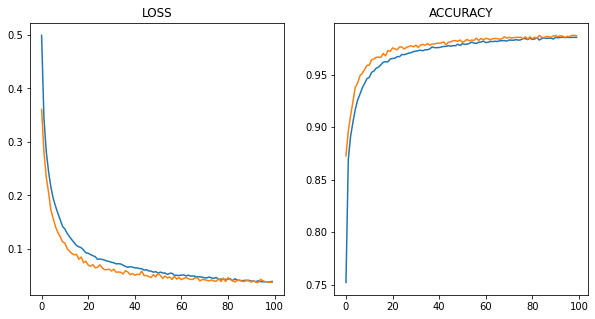

In [11]:
figure, axes = plt.subplots(1, 2)
figure.set_size_inches((10, 5))
epochs = np.arange(len(history.history['loss']))
axes[0].plot(epochs, history.history['loss'])
axes[0].plot(epochs, history.history['val_loss'])
axes[0].set_title("LOSS")

axes[1].plot(epochs, history.history['accuracy'])
axes[1].plot(epochs, history.history['val_accuracy'])
axes[1].set_title("ACCURACY")

plt.show()

In [18]:
test_generator = DataGenerator(32, (32, 32, 1), X_test, y_test)

In [20]:
print("Evaluate on test data")
results = model.evaluate(test_generator)
print("test loss, test acc:", results)


Evaluate on test data
875/875 [==============================] - 2s 3ms/step - loss: 0.0371 - accuracy: 0.9871
test loss, test acc: [0.03711194545030594, 0.9870714545249939]


In [52]:
print(f"ACCURACY: {results[1] * 100:.2f} %")

ACCURACY: 98.71 %


In [42]:
index = np.random.choice(X_test.shape[0], 9, replace=False)  
test_samples = X_test[index].reshape(-1, 32, 32, 1)

In [48]:
test_samples_preds = model.predict(test_samples)
test_samples_preds = np.argmax(test_samples_preds, axis=1)

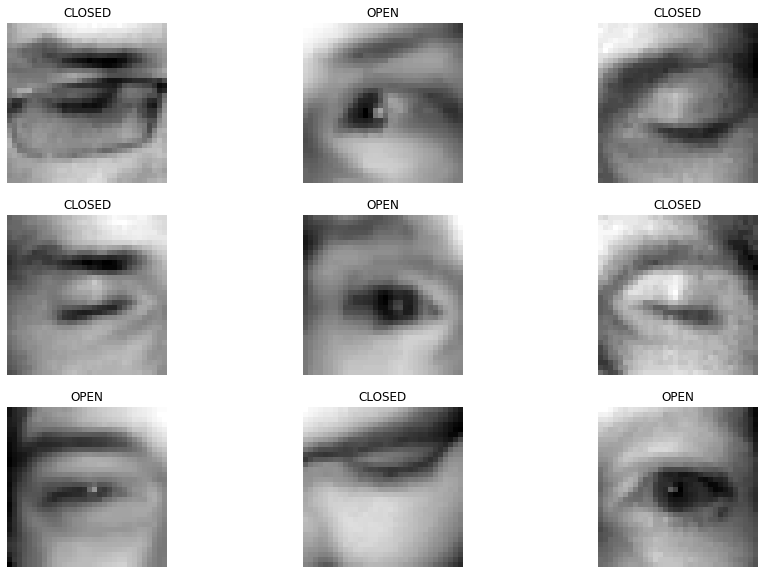

In [50]:
fig, axes = plt.subplots(3, 3)
fig.set_size_inches(15, 10)
axes = axes.flatten()
for idx, ax in enumerate(axes):
  ax.imshow(test_samples[idx, :].reshape(32, 32), cmap='gray')
  ax.axis('off')
  ax.set_title('OPEN' if test_samples_preds[idx] else 'CLOSED')
plt.show()